In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd


## Fitting models to data

<img src="https://raw.githubusercontent.com/harmsm/pythonic-science/master/chapters/02_regression/data/spreadsheet-fit.png" style="margin:auto" />

#### Science often involves fitting quantitative models to data:

 + Fitting a line to a standard curve for an assay
 + Extracting a rate constant from a kinetic assay
 + Estimating the frequency of a genotype in a population
 + Machine learning to make predictions

### How do we do this in python?

### Steps

+ Getting data into python
+ Performing fit
+ Plotting the fit
+ Analyzing the fit (quality, parameter estimates, etc.)

#### How would you read in data that came in a text file formatted like this? 
<img src="https://raw.githubusercontent.com/harmsm/pythonic-science/master/chapters/02_regression/data/dataset-csv.png" style="margin:auto" />

#### We can read files using `pandas`

In [2]:
pd.read_csv("data/test-dataset.csv")

,time,obs
0,0.0,0.000
1,0.5,0.032
2,1.0,0.274
3,1.5,0.264
4,2.0,0.411
5,2.5,0.440
6,3.0,0.517
7,3.5,0.486
8,4.0,0.508
9,4.5,0.651


In [10]:
d = pd.read_csv("data/test-dataset.csv")

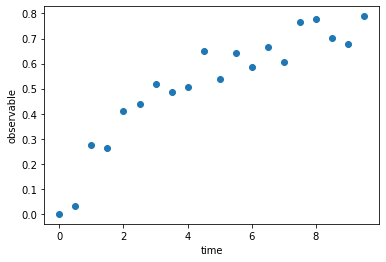

In [14]:
fig, ax = plt.subplots()
ax.plot(d.time,d.obs,"o")
ax.set_xlabel("time")
_ = ax.set_ylabel("observable")

#### How can we fit a model to these data?

In [12]:
import scipy.stats

In [13]:
m, b, r_value, p_value, std_err = scipy.stats.linregress(d.time,
                                                         d.obs)
print("slope:",m)
print("intercept:",b)
print("R squared:",r_value**2)

slope: 0.06962406015037594
intercept: 0.18608571428571435
R squared: 0.8248880797468373


#### What does $R^2$ measure?



+ The amount of variation in the data explained by the model.  
+ $1-R^{2}$ gives how much is determined by some other statistical process (experimental error, complications your model does not capture, etc.)

#### Plot it

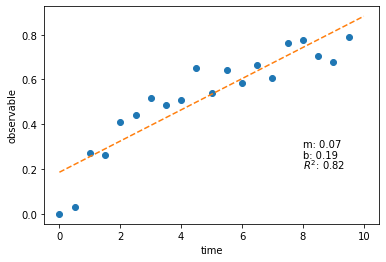

In [16]:

fig, ax = plt.subplots()
ax.plot(d.time,d.obs,"o")
ax.set_xlabel("time")
ax.set_ylabel("observable")

x_range = np.array([0,10]) 
ax.plot(x_range,x_range*m + b,"--")
ax.text(8,0.30,"m: {:.2f}".format(m))
ax.text(8,0.25,"b: {:.2f}".format(b))
ax.text(8,0.20,"$R^{2}$: " + "{:.2f}".format(r_value**2))
None


## What is actually going on in a fit?

#### Let's try fitting manually

In [17]:
def y_calc(x,m,b):
    return m*x + b

### Which model do you prefer and why?

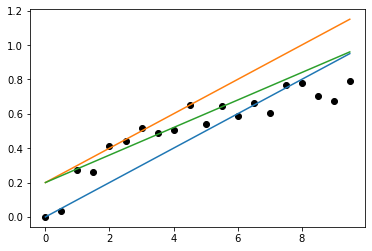

In [18]:
fig, ax = plt.subplots()
ax.plot(d.time,d.obs,"ko")
ax.plot(d.time,y_calc(d.time,m=0.1,b=0))
ax.plot(d.time,y_calc(d.time,m=0.1,b=0.2))
ax.plot(d.time,y_calc(d.time,m=0.08,b=0.2))

#### Implicitly minimizing a *residuals* function

In [19]:
def y_residuals(x_obs,y_obs,m,b):
    
    return (m*x_obs + b) - y_obs

#### The difference between the model `(m*x_obs + b)`  and what we observed `y_obs`.

#### Define a function to plot `y_obs`, `y_calc`, and `y_calc - y_obs`

In [20]:
def plot_figs(x_obs,y_obs,m,b,ax):
    """Convenience plotting function"""
    ax[0].plot(x_obs,y_obs,"ko")
    ax[0].plot(x_obs,y_calc(x_obs,m,b))
    ax[0].set_ylabel("y")
    
    ax[1].plot(x_obs,np.zeros(len(x_obs)),"--",color="gray")
    ax[1].plot(x_obs,y_residuals(x_obs,y_obs,m,b))
    ax[1].set_ylabel("y_model - y_obs")
    ax[1].set_xlabel("x")    

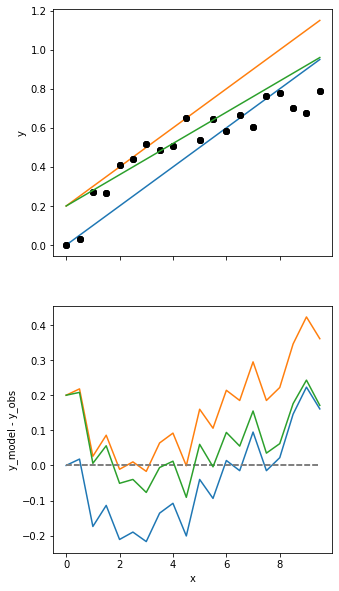

In [21]:
fig, ax = plt.subplots(2,1,figsize=(5,10),sharex=True)
plot_figs(d.time,d.obs,m=0.1,b=0,ax=ax)
plot_figs(d.time,d.obs,m=0.1,b=0.2,ax=ax)
plot_figs(d.time,d.obs,m=0.08,b=0.2,ax=ax)

#### Software minimizes the sum of the squared residuals

$$ SSR = \sum_{i=0}^{i < N} (y_{calc,i} - y_{obs,i})^{2}$$

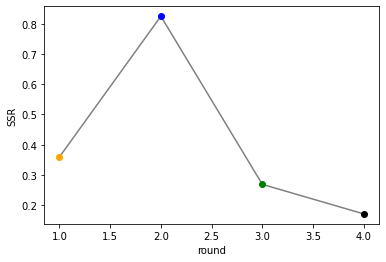

In [23]:
sum_squared_residuals = [np.sum(y_residuals(d.time,d.obs,m=0.10,b=0.0)**2),
                         np.sum(y_residuals(d.time,d.obs,m=0.10,b=0.2)**2),
                         np.sum(y_residuals(d.time,d.obs,m=0.08,b=0.2)**2),
                         np.sum(y_residuals(d.time,d.obs,m=0.0696240601504,b=0.186085714286)**2)]

fig, ax = plt.subplots()
ax.plot([1],sum_squared_residuals[0],"o",color="orange")
ax.plot([2],sum_squared_residuals[1],"o",color="blue")
ax.plot([3],sum_squared_residuals[2],"o",color="green")
ax.plot([4],sum_squared_residuals[3],"o",color="black")

ax.plot([1,2,3,4],sum_squared_residuals,"-",color='gray',zorder=-10)
ax.set_xlabel("round")
ax.set_ylabel("SSR")
None

#### We use sum of squared residuals:
+ Penalizes big deviations a lot.
+ Penalizes both negative and positive deviations equally. 

+ Deep statistical reasons.  Minimizing SSR is a *maximum likelihood* calculation.  (If uncertainty for each point is identical, $SSR \propto -ln(L)$.)

#### Regression ingredients
+ Experimental data
+ Residuals function
+ Way to search through "parameter space"

#### Parameter space
<img src="https://raw.githubusercontent.com/harmsm/pythonic-science/master/chapters/02_regression/data/param-space.png" style="margin:auto" />

### How do we search parameter space?

One example: Nelder-Mead

<img src="https://raw.githubusercontent.com/harmsm/pythonic-science/master/chapters/02_regression/data/00_flip.png" style="margin:auto" height="65%" width="65%"/>

<img src="https://raw.githubusercontent.com/harmsm/pythonic-science/master/chapters/02_regression/data/01_contract.png" style="margin:auto" height="65%" width="65%"/>

<img src="https://raw.githubusercontent.com/harmsm/pythonic-science/master/chapters/02_regression/data/02_shrink.png" style="margin:auto" height="65%" width="65%"/>

In [24]:
%%HTML
<video width="650" height="600" controls="controls"> 
  <source src="https://raw.githubusercontent.com/harmsm/pythonic-science/master/chapters/02_regression/data/simplex.mp4" type="video/mp4">
</video>

### When does this fail?

+ If there is no minimum (or an infinitely long valley)
+ If there are multiple minima
+ If the function has infinities
+ When guesses are so bad you can't reach minimum

### Next class:

+ Implementing residual functions
+ `scipy.optimize.least_squares`

# Do
+ Choose the model that fits the data best with the fewest parameters
+ Check your residuals for randomness 
+ Use a biologically/physically informed model with independently testable/interpretable parameters  

# Don't
+ Try only one set of parameter guesses
+ Overfit your data (fit a model with more parameters than can be reliably estimated)

In [30]:

def some_function(x):
    
    a = x*x
    
    return a, x

    return x + x

y = some_function(5)
print(y)

(25, 5)
